In [1]:
# !pip install pytorch_lightning
# !pip install tensorboardX

In [2]:
from collections import namedtuple

import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as td

import pytorch_lightning as pl

import tqdm
import json
import sklearn.metrics as sm

import tensorboardX as tb
import tensorflow as tf
import datetime, os

import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(31337)

## Create pairs (first track, subsequent track, time)

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

In [4]:
DATA_DIR = "/content/drive/MyDrive/recsys-itmo-2023/seminar_05/"
DATA_DIR = ""

In [5]:
# data = pd.read_json(DATA_DIR + "data_seminar_04.json", lines=True)

data = pd.read_json(DATA_DIR + "1/data.json", lines=True)
t = pd.read_json(DATA_DIR + "1/data.json.1", lines=True)
data = data.append(t, ignore_index=True)
t = pd.read_json(DATA_DIR + "1/data.json.2", lines=True)
data = data.append(t, ignore_index=True)
t = pd.read_json(DATA_DIR + "1/data.json.3", lines=True)
data = data.append(t, ignore_index=True)

In [11]:
data

,message,timestamp,user,track,time,latency,recommendation,experiments
0,next,2023-04-09 10:54:55.430,1912,23482,0.00,0.000396,24191.0,{'CONTEXTUAL': 'C'}
1,next,2023-04-09 10:54:55.440,1912,24191,0.00,0.000437,34972.0,{'CONTEXTUAL': 'C'}
2,last,2023-04-09 10:54:55.450,1912,34972,0.00,0.000185,NaN,{'CONTEXTUAL': 'C'}
3,next,2023-04-09 10:54:55.452,7708,309,1.00,0.000520,11661.0,{'CONTEXTUAL': 'C'}
4,next,2023-04-09 10:54:55.454,8979,2709,1.00,0.000426,12923.0,{'CONTEXTUAL': 'C'}
...,...,...,...,...,...,...,...,...
1712029,next,2023-04-09 10:07:56.721,8885,3894,0.00,0.000497,11049.0,{'CONTEXTUAL': 'T1'}
1712030,next,2023-04-09 10:07:56.723,5339,1490,1.00,0.000508,2669.0,{'CONTEXTUAL': 'T1'}
1712031,last,2023-04-09 10:07:56.724,4112,7690,0.36,0.000125,NaN,{'CONTEXTUAL': 'C'}
1712032,next,2023-04-09 10:07:56.726,8885,11049,0.00,0.000584,2148.0,{'CONTEXTUAL': 'T1'}


In [14]:
Pair = namedtuple("Session", ["user", "start", "track", "time"])

def get_pairs(user_data):
    pairs = []
    first = None
    for _, row in user_data.sort_values("timestamp").iterrows():
        if first is None:
            first = row["track"]
        else:
            pairs.append(Pair(row["user"], first, row["track"], row["time"]))
        
        if row["message"] == "last":
            first = None
    return pairs


def get_pairs_2(user_data):
    pairs = []
    prev = None
    for _, row in user_data.sort_values("timestamp").iterrows():
        if prev is None:
            prev = row["track"]
        else:
            pairs.append(Pair(row["user"], prev, row["track"], row["time"]))
            prev = row["track"]
        
        if row["message"] == "last":
            prev = None
    return pairs

In [15]:
pairs = pd.DataFrame(
    data
    .groupby("user")
    .apply(get_pairs_2)
    .explode()
    .values
    .tolist(),
    columns=["user", "start", "track", "time"]
)

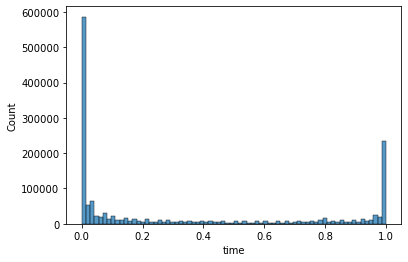

In [16]:
figure, ax = plt.subplots()
sns.histplot(pairs["time"], ax=ax)
pass

## Train Model

In [17]:
rdm = np.random.random(len(pairs))
train_data = pairs[rdm < 0.8]
val_data = pairs[(rdm >= 0.8) & (rdm < 0.9)]
test_data = pairs[rdm >= 0.9]

len(train_data), len(val_data), len(test_data)

(1209944, 150272, 151818)

In [18]:
class ContextualRanker(pl.LightningModule):
    def __init__(self, track_dim=10, context_dim=10, user_dim=10):
        super().__init__()
        self.track_dim = track_dim
        self.context_dim = context_dim
        self.user_dim = user_dim
        
        # We won't have embeddings for everything, but that's ok
        self.track = nn.Embedding(num_embeddings=50000, embedding_dim=self.track_dim)
        self.context = nn.Embedding(num_embeddings=50000, embedding_dim=self.context_dim)
        self.user = nn.Embedding(num_embeddings=10000, embedding_dim=self.user_dim)

    def forward(self, x):
        context = self.context(x[:, 0]) # start track
        track = self.track(x[:, 1]) # next track
        user = self.user(x[:, 2]) # user
        
        user_context = torch.cat((user, context), dim=1)
        
        return torch.sum(user_context * track, dim=1)
            
    def step(self, batch, batch_idx, metric, prog_bar=False):
        x, y = batch
        predictions = self.forward(x)
        loss = F.mse_loss(predictions, y.float(), reduction='mean')
        self.log(metric, loss, prog_bar=prog_bar)
        return loss

    def test_step(self, batch, batch_idx, prog_bar=False):
        x, y = batch
        predictions = self.forward(x)
        targets = y[:, 0].float()
        avgs = y[:, 1].float()
        rdms = y[:, 2].float()

        loss = F.mse_loss(predictions, targets, reduction='mean')
        avg_loss = F.mse_loss(avgs, targets, reduction='mean')
        rdm_loss = F.mse_loss(rdms, targets, reduction='mean')

        self.log("test_loss", loss, prog_bar=prog_bar)
        self.log("avg_loss", avg_loss, prog_bar=prog_bar)
        self.log("rdm_loss", rdm_loss, prog_bar=prog_bar)

    def training_step(self, batch, batch_idx):
        return self.step(batch, batch_idx, "train_loss")
    
    def validation_step(self, batch, batch_idx):
        return self.step(batch, batch_idx, "val_loss", True)
        
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3, weight_decay=1e-5)
        lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, verbose=True)
        scheduler = {
            'scheduler': lr_scheduler,
            'reduce_on_plateau': True,
            'monitor': 'val_loss'
        }
        return [optimizer], [scheduler]

In [19]:
class ContextualRankerData(pl.LightningDataModule):
  def __init__(self, train_data, val_data, test_data, features):
      super().__init__()
      self.train_data = train_data
      self.val_data = val_data
      self.test_data = test_data
      self.features = features

  def prepare_data(self):
      self.test_data = self.test_data.assign(rdm = np.random.random(len(self.test_data))).assign(avg = self.train_data["time"].mean())

  def setup(self, stage=None):
      if stage == "fit" or stage is None:
        self.train_dataset = td.TensorDataset(
            torch.from_numpy(self.train_data[self.features].values), 
            torch.from_numpy(self.train_data["time"].values)
            )

        self.val_dataset = td.TensorDataset(
            torch.from_numpy(self.val_data[self.features].values), 
            torch.from_numpy(self.val_data["time"].values)
            )
        
      if stage == "test" or stage is None:  
        self.test_dataset = td.TensorDataset(
            torch.from_numpy(self.test_data[self.features].values),
            torch.from_numpy(self.test_data[["time", "avg", "rdm"]].values)
        )
  def train_dataloader(self):
      return td.DataLoader(self.train_dataset, batch_size=2048, shuffle=True, num_workers=0)

  def val_dataloader(self):
      return td.DataLoader(self.val_dataset, batch_size=2048, num_workers=0)

  def test_dataloader(self):
      return td.DataLoader(self.test_dataset, batch_size=512, shuffle=False, num_workers=0)

In [20]:
net = ContextualRanker(track_dim=100, context_dim=30, user_dim=70)
data_module = ContextualRankerData(train_data, val_data, test_data, features = ["start", "track", "user"])

checkpoint_callback = pl.callbacks.ModelCheckpoint(monitor="val_loss")

trainer = pl.Trainer(
    max_epochs=300,
    accelerator='gpu', 
    devices=1,
    callbacks=[
        pl.callbacks.early_stopping.EarlyStopping(monitor="val_loss", patience=5),
        pl.callbacks.LearningRateMonitor(logging_interval="step"),
        checkpoint_callback
    ])

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [21]:
# %load_ext tensorboard
# %tensorboard --logdir lightning_logs --host localhost

In [22]:
trainer.fit(
    net, 
    data_module
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type      | Params
--------------------------------------
0 | track   | Embedding | 5.0 M 
1 | context | Embedding | 1.5 M 
2 | user    | Embedding | 700 K 
--------------------------------------
7.2 M     Trainable params
0         Non-trainable params
7.2 M     Total params
28.800    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/denis/anaconda3/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:229: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,
/home/denis/anaconda3/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 00057: reducing learning rate of group 0 to 1.0000e-04.


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 00071: reducing learning rate of group 0 to 1.0000e-05.


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [23]:
best = ContextualRanker.load_from_checkpoint(checkpoint_callback.best_model_path, track_dim=100, context_dim=30,
                                             user_dim=70)

In [24]:
trainer.test(best, data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/denis/anaconda3/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:229: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         avg_loss          │    0.16677704453468323    │
│         rdm_loss          │    0.2757326364517212     │
│         test_loss         │    0.11823105067014694    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.11823105067014694,
  'avg_loss': 0.16677704453468323,
  'rdm_loss': 0.2757326364517212}]

In [16]:
trainer.test(best, data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/denis/anaconda3/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:229: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         avg_loss          │    0.15447917580604553    │
│         rdm_loss          │    0.2776205241680145     │
│         test_loss         │    0.10996723175048828    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.10996723175048828,
  'avg_loss': 0.15447917580604553,
  'rdm_loss': 0.2776205241680145}]

In [26]:
import pickle

def save_pickle(obj, path):
    with open(path, 'wb') as f:
        pickle.dump(obj, f)

def read_pickle(path):
    with open(path, 'rb') as f:
        obj = pickle.load(f)
    return obj

In [27]:
context_embeddings = dict(best.named_parameters())["context.weight"].data.cpu().numpy()
track_embeddings = dict(best.named_parameters())["track.weight"].data.cpu().numpy()
user_embeddings = dict(best.named_parameters())["user.weight"].data.cpu().numpy()

save_pickle(context_embeddings, 'pickles_mine/4/context.pcl')
save_pickle(track_embeddings, 'pickles_mine/4/track.pcl')
save_pickle(user_embeddings, 'pickles_mine/4/user.pcl')

## Compute top recommendations

In [17]:
track_meta = pd.read_json(DATA_DIR + "tracks.json", lines=True)

In [18]:
context_embeddings = dict(best.named_parameters())["context.weight"].data.cpu().numpy()
track_embeddings = dict(best.named_parameters())["track.weight"].data.cpu().numpy()

In [19]:
track_meta.head()

,artist,title,track
0,Jack Johnson,The Cove,0
1,Billy Preston,Nothing from Nothing,1
2,Paco De Lucia,Entre Dos Aguas,2
3,Josh Rouse,Under Cold Blue Stars,3
4,The Dead 60s,Riot Radio (Soundtrack Version),4


In [20]:
k = 100
with open(DATA_DIR + "tracks_with_recs.json", "w") as rf:
    for _, track in tqdm.tqdm(track_meta.iterrows()):
        embedding = context_embeddings[track["track"]]
        neighbours = np.argpartition(-np.dot(track_embeddings, embedding), k)[:k]
        
        recommendation = dict(track)
        recommendation["recommendations"] = neighbours.tolist()
        
        rf.write(json.dumps(recommendation) + "\n")

50000it [00:57, 874.97it/s]


In [21]:
track = 3916
embedding = context_embeddings[track]
track_meta.loc[track_meta["track"] == track, ["artist", "title"]]

,artist,title
3916,Florence + The Machine,Bird Song


In [22]:
k = 10
neighbours = np.argpartition(-np.dot(track_embeddings, embedding), k)[:k]
track_meta.loc[track_meta["track"].isin(neighbours), ["artist", "title"]]

,artist,title
140,Justin Bieber,Somebody To Love
171,OneRepublic,Secrets
191,Coldplay,Yellow
388,Metric,Gold Guns Girls
442,Taylor Swift,Love Story
444,B.o.B,Nothin' On You [feat. Bruno Mars] (Album Version)
1087,Bon Iver,Skinny Love
1472,Beyoncé,Halo
1530,Linkin Park,In The End (Album Version)
3590,The Ruts,West One (Shine On Me)
